In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Affine:
    def __init__(self, input_dim, output_dim): #편향은 인풋에는 미포함 
        self.input_dim = input_dim
        self.output_dim = output_dim 
        self.W = np.random.randn(self.input_dim+1, self.output_dim)*0.01 #표준편차 0.01인 정규분포로 초기화
        self.dW = None # 가중치 업데이트를 위한 텀 
        
    def forward(self, x): # numpy 1차원 배열 혹은 1행 행렬을 입력으로 받음
        self.x = np.array( [1]+list(x.reshape(-1))).reshape(1,-1) # 편향을 위한 1을 삽입하고 행렬로 변환
        return np.dot(self.x, self.W)
    
    def backward(self, dout): #dout = dL/dY
        self.dW = np.dot(self.x.T, dout) #가중치 편미분
        dX = np.dot(dout, self.W.T) #입력데이터 편미분
        return dX[:,1:]
        

In [3]:
fc1 = Affine(3, 10)

In [4]:
x = np.array([[1,1,1]])
fc1.forward(x)

array([[-0.03357286,  0.00180713,  0.01083531,  0.03140882, -0.01583786,
        -0.00381434,  0.00732589,  0.00998906, -0.00813555,  0.02102911]])

In [5]:
class mse_loss_layer:
    def __init__(self):
        self.y, self.t = None, None
        self.dW = None # 가중치 업데이트를 위한 텀.
        pass
    
    def loss(self, y, t): #t : target value
        self.y = y
        self.t = t
        return np.sum((y-t)**2)
    
    def backward(self):
        return self.y - self.t

In [6]:
data = np.load('lr_data.npy')
data.shape

(25, 2)

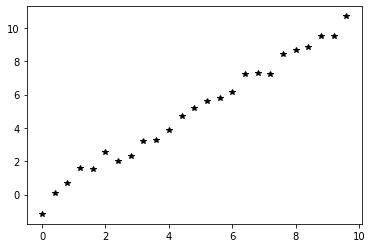

In [7]:
xdata = data[:,0]
ydata = data[:,1]
plt.plot(xdata,ydata,'k*')
plt.show()

In [8]:
class one_layer_reg:
    def __init__(self, input_dim, output_dim):
        self.fc1 = Affine(input_dim, output_dim)
        self.mse_loss = mse_loss_layer()
        self.layers = [self.fc1, self.mse_loss]
        pass
    
    def forward(self, x):
        return self.fc1.forward(x)

In [9]:
test1 = one_layer_reg(1,1)

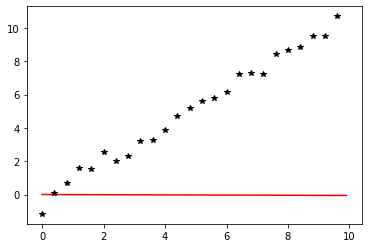

In [10]:
pred_y =[test1.forward(np.array([x])) for x in np.arange(0,10,0.1)]
pred_y =np.array(pred_y).reshape(-1)
plt.plot(np.arange(0,10,0.1), pred_y, 'r-')
plt.plot(xdata, ydata, 'k*')
plt.show()

In [11]:
class trainer:
    def __init__(self, net, lr, xdata, ydata): #네트워크, 학습율, 인풋데이타, 정답데이터 
        self.net = net
        self.lr = lr
        self.xdata = xdata
        self.ydata = ydata
        self.loss_history =[]
        pass
    
    def loss(self):
        a = 0
        for x,y in zip(self.xdata,self.ydata):
            a+=self.net.layers[-1].loss(self.net.forward(x),y)
        return a
    
    def grad(self, x, t):
        y = self.net.forward(x)
        self.net.layers[-1].loss(y, t)
        dout = self.net.layers[-1].backward()
        for layer in self.net.layers[::-1][1:]:
            dout = layer.backward(dout)
        grads = [a.dW if type(a.dW) != type(None) else 0 for a in self.net.layers]
        return grads
    
    def update(self, num_epoch):
        for _ in range(num_epoch):
            self.loss_history.append(self.loss())
            grads =[ np.zeros_like(a.dW) if type(a.dW) != type(None) \
                    else 0 for a in self.net.layers]
            
            for x,y in zip(self.xdata,self.ydata):
                temp = self.grad(x,y)
                grads = [dw+dwi for dw,dwi in zip(grads,temp)]
            
            for i, dw in enumerate(grads):
                if type(dw) != int:
                    self.net.layers[i].W -= self.lr * dw
        
        plt.plot(self.loss_history,'k-')
        return plt.show()
                    
            

In [12]:
train_x = np.array([np.array([x]) for x in xdata])
train_y = np.array([np.array([y]) for y in ydata])
print(train_x.shape)
print(train_y.shape)

(25, 1)
(25, 1)


In [13]:
tt = trainer(test1, 0.001, train_x, train_y)

In [14]:
tt.loss()

899.4967773205472

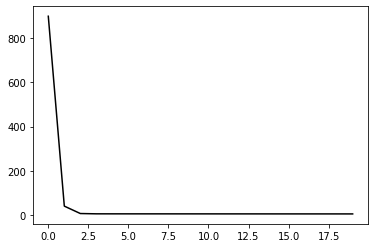

In [15]:
tt.update(20)

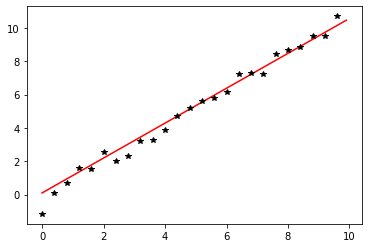

In [16]:
pred_y =[test1.forward(np.array([x])) for x in np.arange(0,10,0.1)]
pred_y =np.array(pred_y).reshape(-1)
plt.plot(np.arange(0,10,0.1), pred_y, 'r-')
plt.plot(xdata, ydata, 'k*')
plt.show()

In [17]:
# 스탠포드대학교 cs231n의 분류 예시 데이터를 약간 변형해서 만들어진 데이터.
c2_data = np.load('2class_data.npy')
c2_data.shape

(100, 3)

In [18]:
c2_data[10]

array([0.14294951, 0.14565284, 0.        ])

In [19]:
p_data = c2_data[:,:2] # 위치데이터
c_data = c2_data[:,2]  # class 데이터 

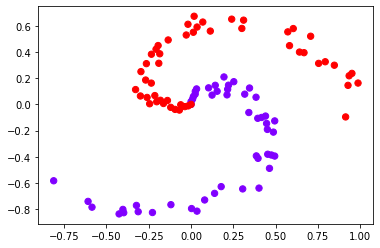

In [20]:
plt.scatter(p_data[:, 0], p_data[:, 1], c=c_data, s=40, cmap=plt.cm.rainbow)
plt.show()

In [21]:
class Relu:
    def __init__(self):
        self.mask = None # < 0 컨디션 만족여부 저장용
        self.dW = None # 가중치 업데이트를 위한 텀.
        pass
    
    def forward(self, x):
        self.mask = ( x < 0 ) 
        x[self.mask] = 0
        return x 
    
    def backward(self, dout):
        dout[self.mask ] =0
        return dout

In [22]:
act = Relu()

In [23]:
act.forward(np.array([1,-1,1,1]))

array([1, 0, 1, 1])

In [24]:
act.mask

array([False,  True, False, False])

In [25]:
class Softmax:
    def __init__(self):
        self.dW = None
        pass
    
    def forward(self, x):
        x = x - np.max(x)
        out = np.exp(x)
        out /= np.sum(out)
        return out
    
    def backward(self, dout): #coding 편의를 위해 loss 클래스에서 한꺼번에 계산예정
        return dout
        

In [26]:
sm = Softmax()

In [27]:
sm.forward(np.array([10,-1,-2,5]))

array([9.93284608e-01, 1.65895423e-05, 6.10295156e-06, 6.69269905e-03])

In [28]:
class Cross_entropy_loss:
    def __init__(self):
        self.y, self.t = None, None
        self.dW = None
        pass
    
    def loss(self, y, t):
        self.y, self.t = y, t
        loss = -np.log(y[:,np.argmax(t)]+1e-8)
        return loss
    
    def backward(self):
        return self.y - self.t

In [29]:
class one_layer_cfn:
    def __init__(self):
        self.fc1 = Affine(2, 2)
        self.sm = Softmax()
        self.ce_loss = Cross_entropy_loss()
        self.layers = [self.fc1, self.sm, self.ce_loss]
        pass
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer.forward(x)
        return x
        

    def predict(self, x):
        return np.argmax(self.forward(x))
    
    def accuracy(self, xdata, ydata):
        cnt = 0
        for x, t in zip(xdata, ydata):
            if self.predict(x) == np.argmax(t):
                cnt +=1
        ratio = 100*cnt / xdata.shape[0]
        print("분류 성공율: %.2f%%" %ratio)
        pass

In [32]:
train_x = p_data[:]
train_y = np.zeros([train_x.shape[0], 2])
for i, item in enumerate(train_y):
    item[int(c_data[i])] = 1.
train_y = np.array([ [y] for y in train_y])
train_x[0].shape

(2,)

In [33]:
test2 = one_layer_cfn()

In [34]:
test2.accuracy(train_x, train_y)

분류 성공율: 65.00%


In [35]:
tt2 = trainer(test2, 1e-3, train_x, train_y)

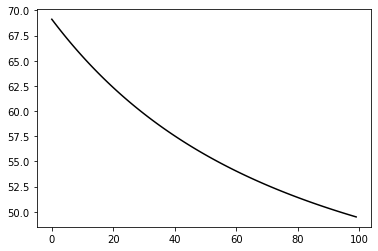

In [36]:
tt2.update(100)

In [37]:
tt2.net.accuracy(train_x, train_y)

분류 성공율: 74.00%


In [38]:
X, Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))

In [39]:
Z = [ tt2.net.predict(np.array([X[i,j], Y[i,j]])) for i in range(100) for j in range(100) ]
Z = np.array(Z)
Z = Z.reshape(100,100)

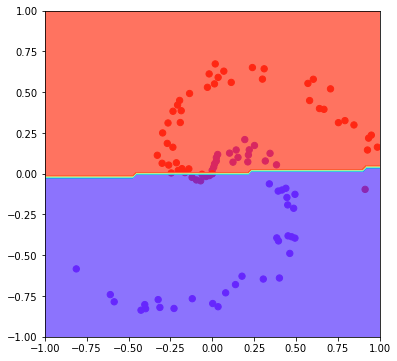

In [40]:
plt.figure(figsize=(6,6))
plt.scatter(p_data[:, 0], p_data[:, 1], c=c_data, s=40, cmap=plt.cm.rainbow)
plt.contourf(X,Y, Z, alpha=.7, cmap=plt.cm.rainbow)
plt.show()

In [41]:
class two_layer_cfn:
    def __init__(self):
        self.fc1 = Affine(2, 100)
        self.fc1_act = Relu()
        self.fc2 = Affine(100,2)
        self.sm = Softmax()
        self.ce_loss = Cross_entropy_loss()
        self.layers = [self.fc1, self.fc1_act, self.fc2, self.sm, self.ce_loss]
        pass
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer.forward(x)
        return x
    
    def predict(self, x):
        return np.argmax(self.forward(x))
    
    def accuracy(self, xdata, ydata):
        cnt = 0
        for x, t in zip(xdata, ydata):
            if self.predict(x) == np.argmax(t):
                cnt +=1
        ratio = 100*cnt / xdata.shape[0]
        print("분류 성공율: %.2f%%" %ratio)
        pass

In [42]:
test3 = two_layer_cfn()

In [43]:
tt3 = trainer(test3, 5e-3, train_x, train_y)

In [44]:
tt3.net.accuracy(train_x, train_y)

분류 성공율: 50.00%


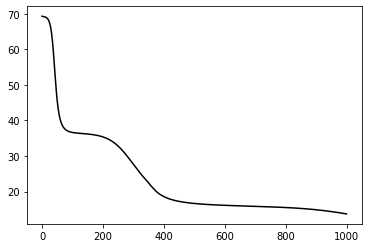

In [45]:
tt3.update(1000)

In [46]:
test3.accuracy(train_x,train_y)

분류 성공율: 91.00%


In [47]:
Z = [ test3.predict(np.array([X[i,j], Y[i,j]])) for i in range(100) for j in range(100) ]
Z = np.array(Z)
Z = Z.reshape(100,100)

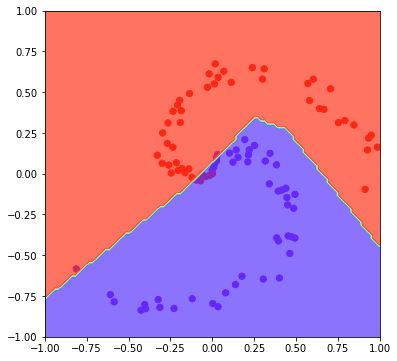

In [48]:
plt.figure(figsize=(6,6))
plt.scatter(p_data[:, 0], p_data[:, 1], c=c_data, s=40, cmap=plt.cm.rainbow)
plt.contourf(X,Y, Z, alpha=.7, cmap=plt.cm.rainbow)
plt.show()

In [49]:
class three_layer_cfn:
    def __init__(self):
        self.fc1 = Affine(2, 100)
        self.fc1_act = Relu()
        self.fc2 = Affine(100,100)
        self.fc2_act = Relu()
        self.fc3 = Affine(100,2)
        self.sm = Softmax()
        self.ce_loss = Cross_entropy_loss()
        self.layers = [self.fc1, self.fc1_act, self.fc2, self.fc2_act, self.fc3, self.sm, self.ce_loss]
        pass
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer.forward(x)
        return x
    
    def predict(self, x):
        return np.argmax(self.forward(x))
    
    def accuracy(self, xdata, ydata):
        cnt = 0
        for x, t in zip(xdata, ydata):
            if self.predict(x) == np.argmax(t):
                cnt +=1
        ratio = 100*cnt / xdata.shape[0]
        print("분류 성공율: %.2f%%" %ratio)
        pass

In [50]:
tt4 = three_layer_cfn()

In [51]:
tt4.accuracy(train_x, train_y)

분류 성공율: 50.00%


In [52]:
test4 = trainer(tt4, 5e-3, train_x, train_y)

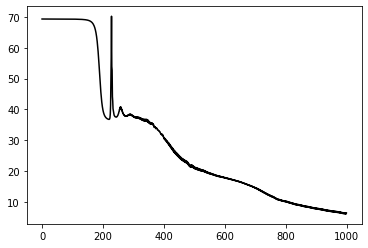

In [53]:
test4.update(1000)

In [54]:
tt4.accuracy(train_x,train_y)

분류 성공율: 97.00%


In [55]:
Z = [ test3.predict(np.array([X[i,j], Y[i,j]])) for i in range(100) for j in range(100) ]
Z = np.array(Z)
Z = Z.reshape(100,100)

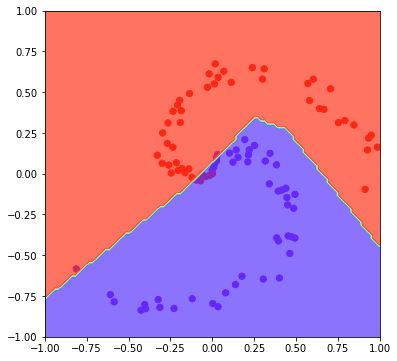

In [56]:
plt.figure(figsize=(6,6))
plt.scatter(p_data[:, 0], p_data[:, 1], c=c_data, s=40, cmap=plt.cm.rainbow)
plt.contourf(X,Y, Z, alpha=.7, cmap=plt.cm.rainbow)
plt.show()